# **Import Librabries**

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4') # Often needed for WordNetLemmatizer
# nltk.download('punkt') # For word_tokenize
# !pip install xgboost lightgbm scikit-learn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import joblib

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# **Basic Dataset Information**

- Total **78313** rows and **22** columns
- There are **21** `categorical` columns and **1** `numerical` column
- **Missing values** for some columns, up to <i>99%</i> for "_source.company_public_response"
- <i>73%</i> **missing data** for "_source.complaint_what_happened" column
- **All zeros** for the "_score" (numerical variable)
- **No duplicated** records
- "_index", "_type", "_score" and "_source.company" have only **1 unique value**
- "_id" is an **unique identifier**

In [8]:
path = "/content/drive/MyDrive/complaints-2021-05-14_08_16.json"
file = open(path)
data= json.load(file)
df = pd.json_normalize(data)

### a. Dataset size

In [ ]:
df.shape

(78313, 22)

### b. Datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

### c. Missing values

In [ ]:
for col in df.columns:
  missing_values = df[col].isnull().sum()
  if missing_values != 0:
    missing_values_perc = missing_values / df.shape[0]
    print(f"{col} : {missing_values_perc*100:.2f}%")

_source.tags : 86.08%
_source.zip_code : 8.63%
_source.state : 2.54%
_source.company_public_response : 99.99%
_source.sub_product : 13.50%
_source.sub_issue : 59.12%
_source.consumer_consent_provided : 1.29%


In [ ]:
df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].replace("",np.nan)
missing_values_perc = df['_source.complaint_what_happened'].isnull().sum()/df.shape[0]
print(f"Missing values : {missing_values_perc*100:.2f}%")

Missing values : 73.09%


### d. Numerical Values Distribution

In [ ]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### Duplicated Rows

In [ ]:
# Find all duplicate rows across all columns (including the first occurrence of a duplicate)
duplicate_rows_all_columns = df[df.duplicated(keep=False)]

print(f"Number of completely duplicated rows: {len(duplicate_rows_all_columns)}")

Number of completely duplicated rows: 0


### Unique Values

In [ ]:
for col in df.columns:
  print(f"{col} : {df[col].nunique()}")

_index : 1
_type : 1
_id : 78313
_score : 1
_source.tags : 3
_source.zip_code : 9442
_source.complaint_id : 78313
_source.issue : 154
_source.date_received : 3444
_source.state : 62
_source.consumer_disputed : 3
_source.product : 17
_source.company_response : 8
_source.company : 1
_source.submitted_via : 6
_source.date_sent_to_company : 3309
_source.company_public_response : 3
_source.sub_product : 72
_source.timely : 2
_source.complaint_what_happened : 20930
_source.sub_issue : 205
_source.consumer_consent_provided : 5


# **Univariate Analysis**

In [ ]:
cat_cols = ["_source.tags", "_source.issue", "_source.state", "_source.consumer_disputed", "_source.product", "_source.company_response", "_source.submitted_via", "_source.company_public_response", "_source.sub_product", "_source.timely", "_source.consumer_consent_provided"]

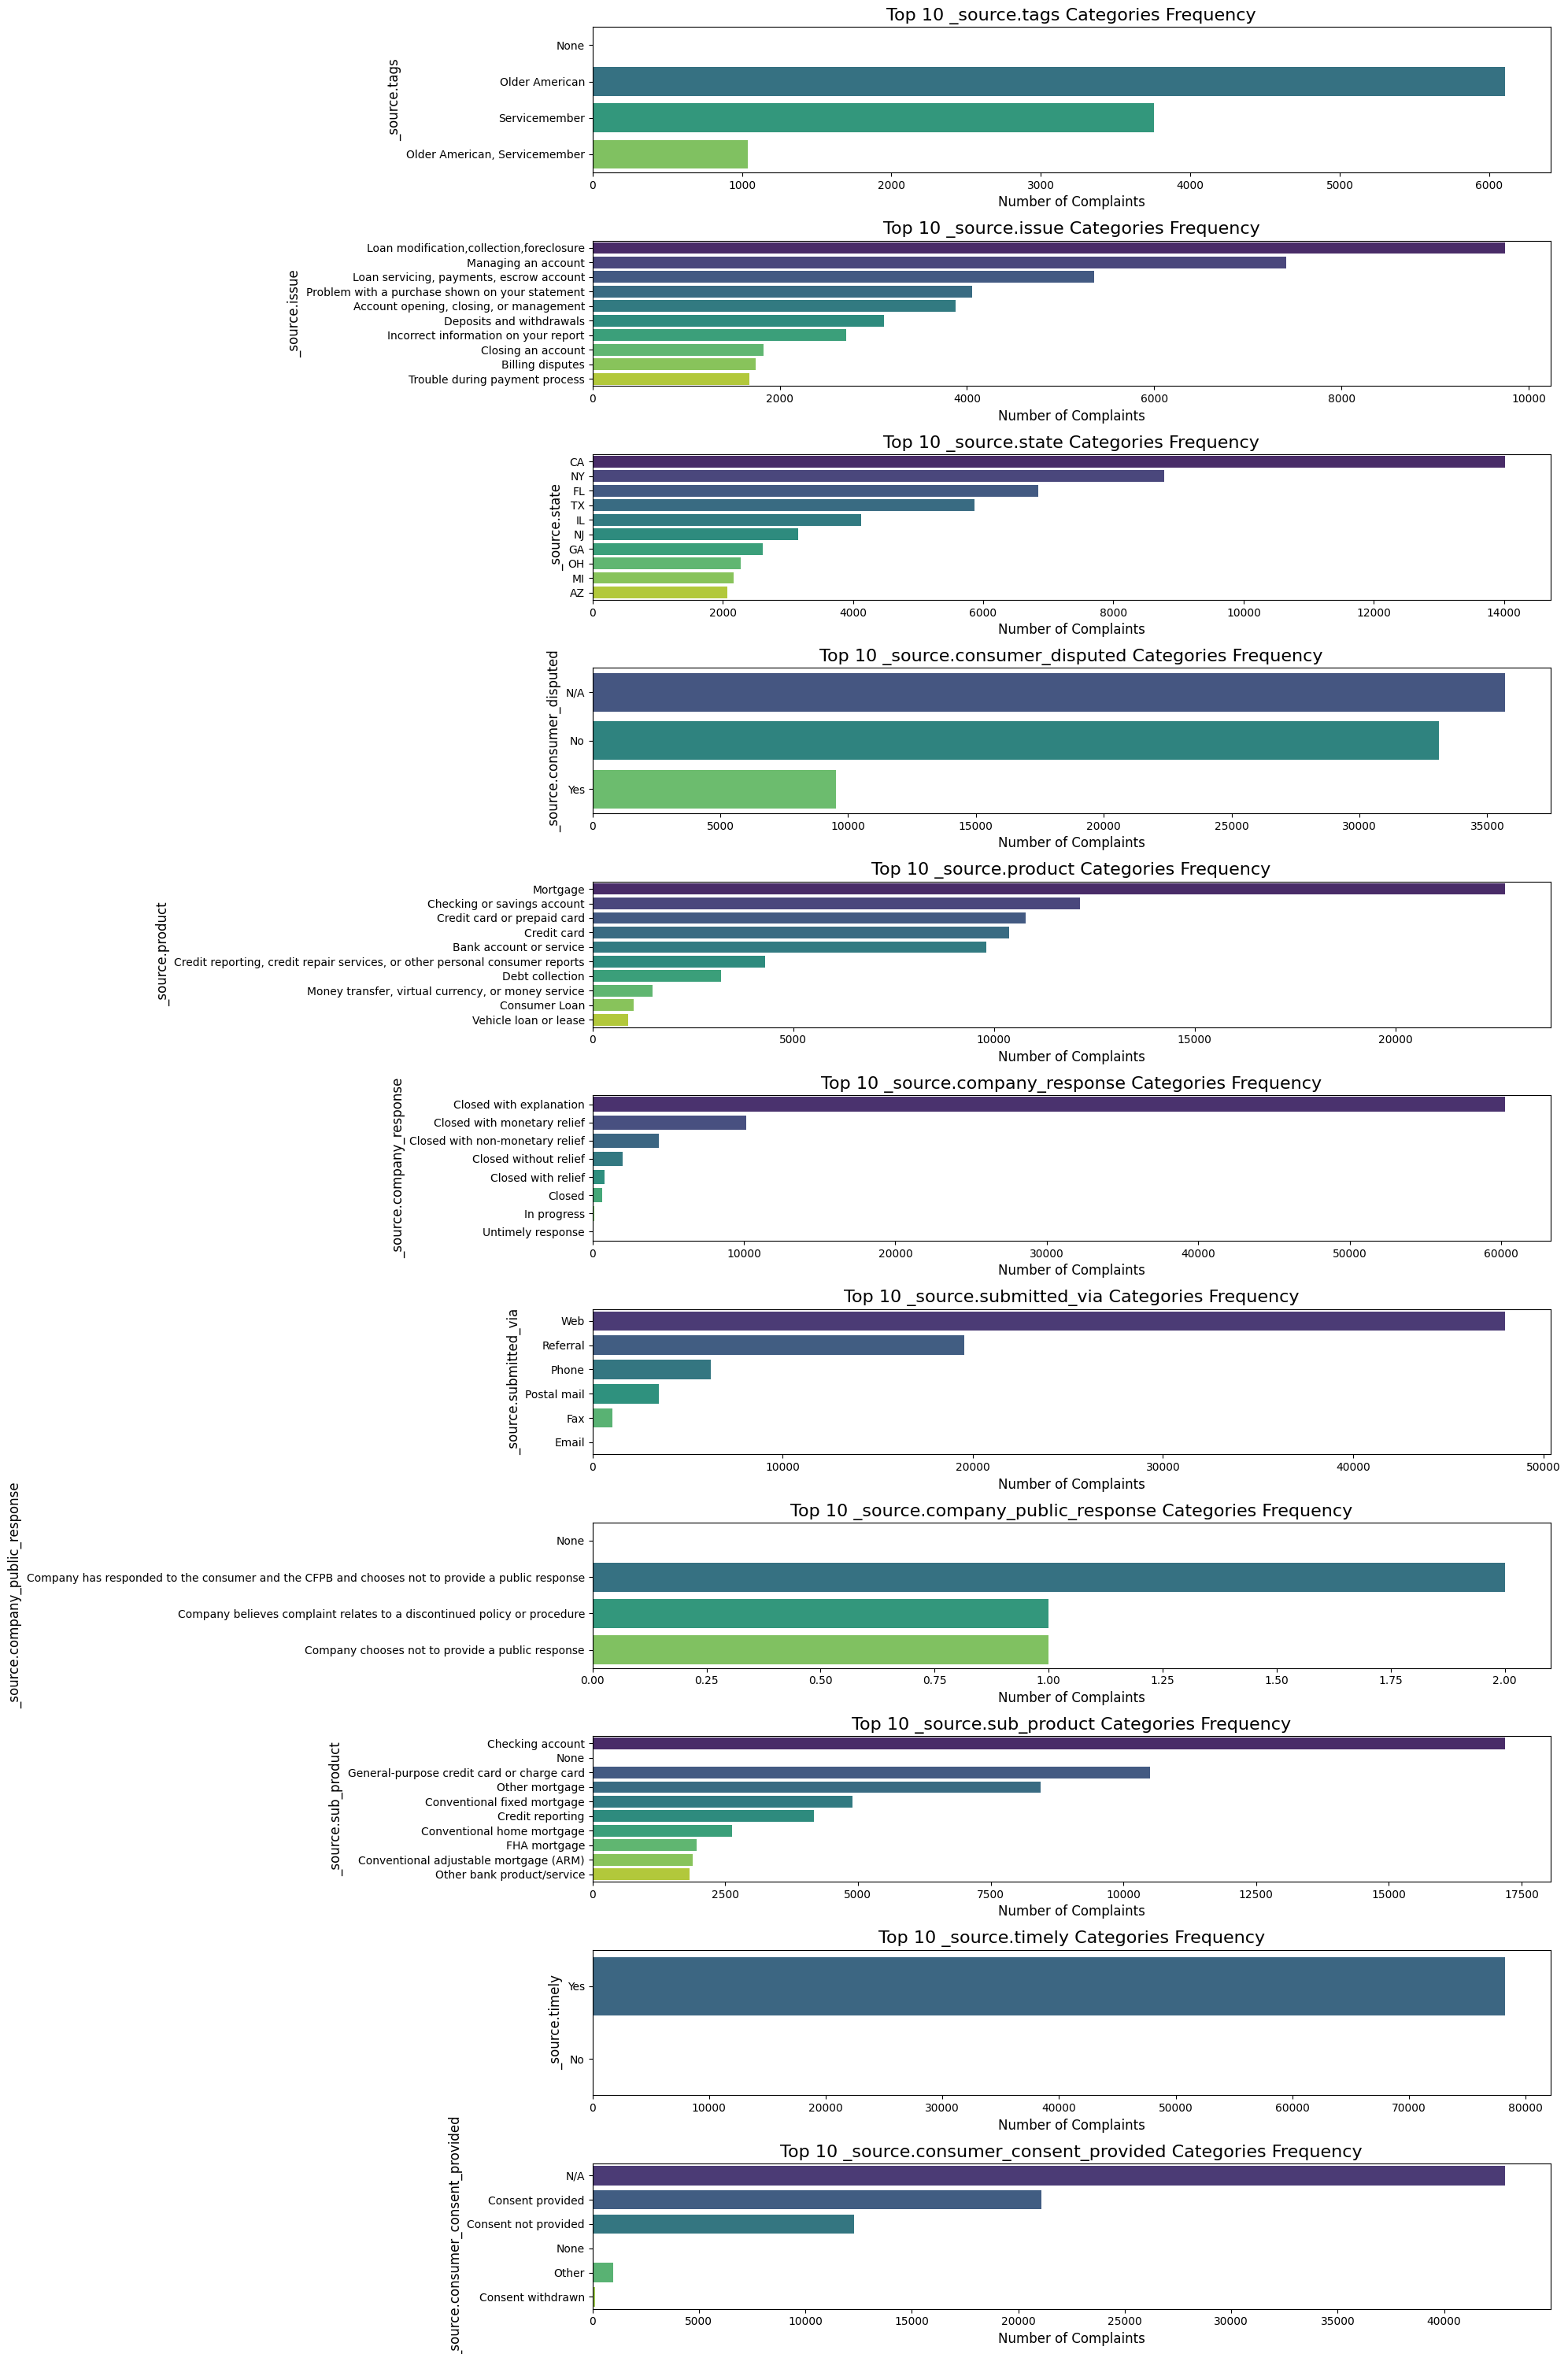

In [ ]:
fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(20,30))
for i, col in enumerate(cat_cols):

    # Get value counts and proportions
    value_counts = df[col].value_counts(dropna=False) # Include NaN in counts

    # Filter for top N categories to avoid overly crowded plots
    top_n = value_counts.head(10).index.tolist() # Selects top 10 categories for plotting

    # Use Seaborn to create a countplot (bar graph of frequencies)
    sns.countplot(data=df[df[col].isin(top_n)], y=col, order=top_n, palette='viridis', ax=ax[i])

    # Add professional titles and labels
    ax[i].set_title(f'Top 10 {col} Categories Frequency', fontsize=16)
    ax[i].set_xlabel('Number of Complaints', fontsize=12)
    ax[i].set_ylabel(col, fontsize=12)

# Apply tight layout once after all subplots are created
plt.tight_layout()

# Display the figure once after all plots are complete
plt.show()

# **Text preprocessing**

In [9]:
def clean_text(text):
    if pd.isna(text): # If the input 'text' is NaN, return an empty string
        return ""
    text = str(text).lower() # Convert text to string type and then to lowercase
    text = re.sub(r'\[.*?\]', '', text) # Remove text enclosed in square brackets
    text = re.sub(r'[^a-z\s]', '', text) # Remove all characters that are NOT lowercase English letters or whitespace
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple consecutive whitespace characters with a single space and remove leading/trailing spaces
    return text

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    cleaned_text = clean_text(text)
    if not cleaned_text: # If the text becomes empty after initial cleaning, return empty string
        return ""
    doc = nlp(cleaned_text)
    processed_tokens = [
        token.lemma_ for token in doc # 'token.lemma_' gets the base form of the word
        if not token.is_stop and token.is_alpha # 'token.is_stop' checks if the token is a stop word (according to spaCy's model),'token.is_alpha' checks if the token consists only of alphabetic characters
    ]
    return " ".join(processed_tokens) # Join the processed tokens back into a single string

# Fill NaN values in the text columns with empty strings before processing
df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].fillna('')
df['_source.issue'] = df['_source.issue'].fillna('')
df['_source.sub_issue'] = df['_source.sub_issue'].fillna('')
df['_source.sub_product'] = df['_source.sub_product'].fillna('')

# Apply preprocessing
df['cleaned_complaint_what_happened'] = df['_source.complaint_what_happened'].apply(preprocess_text)
df['cleaned_issue'] = df['_source.issue'].apply(preprocess_text)
df['cleaned_sub_issue'] = df['_source.sub_issue'].apply(preprocess_text)
df['cleaned_sub_product'] = df['_source.sub_product'].apply(preprocess_text)

In [10]:
def combine_unique_text(row):
    # Get text from all three columns
    texts = [
        row['cleaned_complaint_what_happened'] if pd.notna(row['cleaned_complaint_what_happened']) else "",
        row['cleaned_issue'] if pd.notna(row['cleaned_issue']) else "",
        row['cleaned_sub_issue'] if pd.notna(row['cleaned_sub_issue']) else "",
        row['cleaned_sub_product'] if pd.notna(row['cleaned_sub_product']) else ""
    ]

    # Combine all non-empty texts
    combined = " ".join([text for text in texts if text.strip()])

    if not combined.strip():
        return ""

    # Split into words and remove duplicates while preserving order
    words = combined.split()
    unique_words = []
    seen = set()

    for word in words:
        if word and word not in seen:
            unique_words.append(word)
            seen.add(word)

    return " ".join(unique_words)

# Create the combined column
df['combined_cleaned_text'] = df.apply(combine_unique_text, axis=1)


--- Word Frequency Analysis for 'combined cleaned text' ---


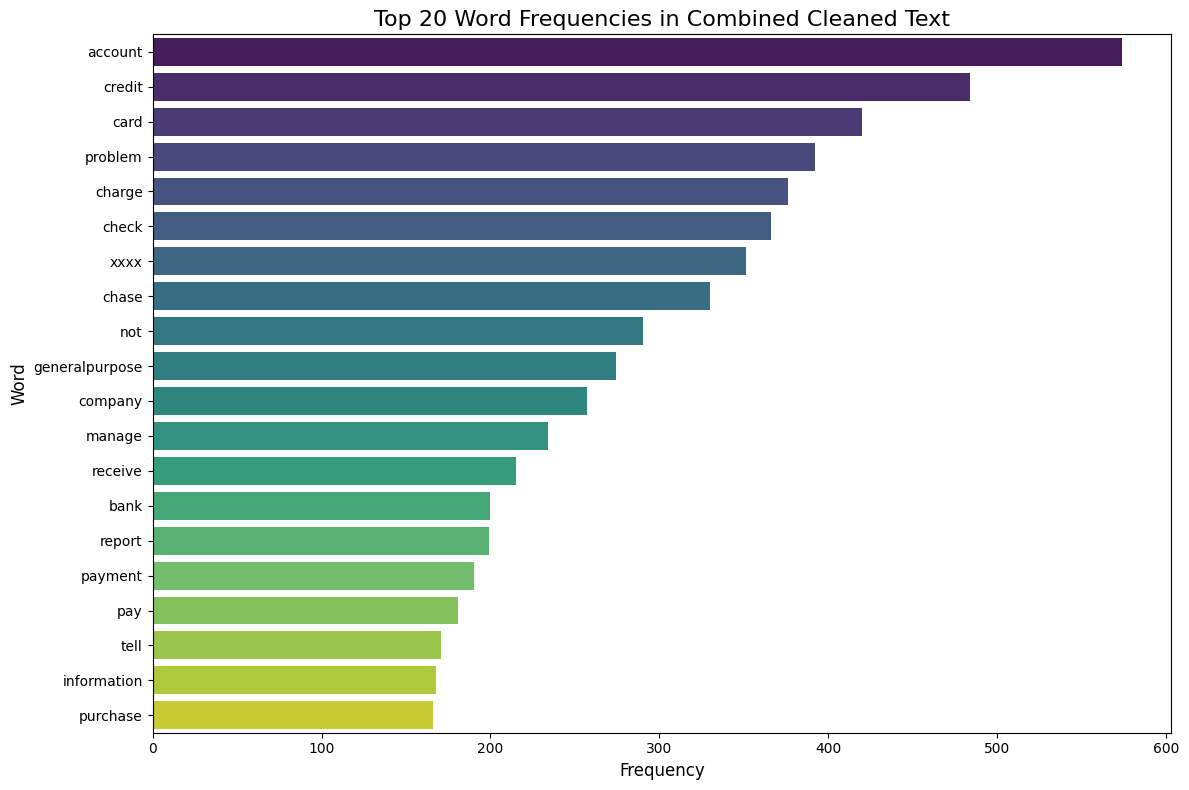

In [18]:
def plot_top_word_frequencies(text_series, title, top_n=20):
    """
    Calculates word frequencies and plots the top N words.
    text_series: A pandas Series containing cleaned text strings.
    title: Title for the plot.
    top_n: Number of top words to display.
    """
    # Combine all text into a single string
    all_text = ' '.join(text_series)

    # Tokenize the combined text
    words = all_text.split() # Using split as our preprocessing already handles basic tokenization

    # Count word frequencies
    word_counts = Counter(words)

    # Get the top N most common words
    most_common_words = word_counts.most_common(top_n)

    if not most_common_words:
        print(f"No words found to plot for {title}. Check if text_series is empty after cleaning.")
        return

    # Prepare data for plotting
    words_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

    # Create the bar graph
    plt.figure(figsize=(12, 8))
    sns.barplot(x='frequency', y='word', data=words_df, palette='viridis')
    plt.title(f'Top {top_n} Word Frequencies in {title}', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.tight_layout()
    plt.show()

# Generate plots for the combined text column
print("\n--- Word Frequency Analysis for 'combined cleaned text' ---")
plot_top_word_frequencies(df['combined_cleaned_text'],
                          'Combined Cleaned Text')

# **Data Pre-processing**

In [ ]:
df = df.iloc[:500,:] # Use subset of first 500 rows due to computational constraints

### TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.8)

# Fit the vectorizer to your cleaned complaint text and transform it
X = vectorizer.fit_transform(df['combined_cleaned_text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf_feature_names)
df = df.reset_index(drop=True)
combined_df = pd.concat([df, df_tfidf], axis=1)

### Remove Placeholder

In [12]:
pattern = re.compile(r'x{4,}') # Matches 'x' repeated 4 or more times (e.g., 'xxxx', 'xxxxx', 'xxxxxx', etc.)

columns_to_remove = []
for col_name in tfidf_feature_names:
    # Search for the pattern anywhere in the column name
    if pattern.search(col_name):
        columns_to_remove.append(col_name)

combined_df_filtered = combined_df.drop(columns=columns_to_remove)

### Label Encoder

In [13]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the variables
combined_df_filtered['_source.product'] = label_encoder.fit_transform(combined_df_filtered['_source.product'])
combined_df_filtered['_source.state'] = label_encoder.fit_transform(combined_df_filtered['_source.state'])

### One Hot Encoder

In [14]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Add handle_unknown to deal with potential unseen categories later, and sparse_output=False for direct DataFrame creation

# Define the columns to be one-hot encoded
columns_to_encode = ['_source.company_response', '_source.submitted_via', '_source.timely']

# Fit and transform the variables
ohc_data = one_hot_encoder.fit_transform(combined_df_filtered[columns_to_encode])

# Get the column names for the new one-hot encoded features
ohc_feature_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Convert the numpy array back into a DataFrame
df_ohc = pd.DataFrame(ohc_data, columns=ohc_feature_names)

# Ensure combined_df_filtered has a reset index if necessary before concatenating
combined_df_filtered = combined_df_filtered.reset_index(drop=True)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
combined_df_filtered = pd.concat([combined_df_filtered, df_ohc], axis=1)

### Impute Missing Values

In [15]:
# Impute missing values with mode for the two specific columns
combined_df_filtered['_source.state'] = combined_df_filtered['_source.state'].fillna(combined_df_filtered['_source.state'].mode()[0])
combined_df_filtered['_source.sub_product'] = combined_df_filtered['_source.sub_product'].fillna(combined_df_filtered['_source.sub_product'].mode()[0])

### Drop Unecessary Columns

- Drop `_source.consumer_disputed` (45%), `_source.consumer_consent_provided` (54%), `_source.tags` (86%) and `_source.company_public_response` (99%) because it has too many missing values
- Drop `_index`, `_type`, `_score` and `_source.company` because they only have 1 unique value
- Drop `_source.zip_code` because there are too many unique values
- Drop `_id` and `_source.complaint_id` because they are unique identifiers
- Drop `_source.date_received` and `_source.date_received` because they are date columns
- Drop `_source.complaint_what_happened`, `_source.sub_issue`, `cleaned_complaint_what_happened` and `cleaned_sub_issue` because already created TF-IDF features
- Drop `_source.company_response`

In [16]:
final_df = combined_df_filtered.drop(["_index", "_type", "_id", "_score", "_source.zip_code", "_source.complaint_id", "_source.issue", "_source.date_received", "_source.date_sent_to_company", "_source.company", "_source.complaint_what_happened", "_source.sub_issue", "cleaned_complaint_what_happened", "cleaned_issue", "cleaned_sub_issue", "_source.tags", "_source.company_public_response", "_source.consumer_disputed", "_source.consumer_consent_provided", "_source.sub_product", "cleaned_sub_product", "combined_cleaned_text", "_source.company_response", "_source.submitted_via", "_source.timely"], axis=1)

# **Train Test Split**

In [17]:
X = final_df.drop('_source.product', axis=1)  # All columns except target
y = final_df['_source.product']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# **Cross Validaton**

In [20]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Dictionary to store results
results = {}

print("Training and Evaluating Models with Cross-Validation...")
print("=" * 60)

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{name}")
    print("-" * 30)

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision_weighted')
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall_weighted')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

    # Store results
    results[name] = {
        'CV_Accuracy_Mean': cv_scores.mean(),
        'CV_Accuracy_Std': cv_scores.std(),
        'CV_Precision_Mean': cv_precision.mean(),
        'CV_Recall_Mean': cv_recall.mean(),
        'CV_F1_Mean': cv_f1.mean()
    }

    # Print results
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Cross-Validation Precision: {cv_precision.mean():.4f}")
    print(f"Cross-Validation Recall: {cv_recall.mean():.4f}")
    print(f"Cross-Validation F1-Score: {cv_f1.mean():.4f}")

# Create results DataFrame for comparison
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\n" + "=" * 80)
print("FINAL RESULTS COMPARISON")
print("=" * 80)
print(results_df)

# Find best performing models
print("\n" + "=" * 50)
print("BEST PERFORMING MODELS")
print("=" * 50)
print(f"Best CV Accuracy: {results_df['CV_Accuracy_Mean'].idxmax()} ({results_df['CV_Accuracy_Mean'].max():.4f})")
print(f"Best CV Recall: {results_df['CV_Recall_Mean'].idxmax()} ({results_df['CV_Recall_Mean'].max():.4f})")
print(f"Best CV Precision: {results_df['CV_Precision_Mean'].idxmax()} ({results_df['CV_Precision_Mean'].max():.4f})")
print(f"Best CV F1-Score: {results_df['CV_F1_Mean'].idxmax()} ({results_df['CV_F1_Mean'].max():.4f})")

# Detailed analysis for the best model (based on CV accuracy)
best_model_name = results_df['CV_Accuracy_Mean'].idxmax()
best_model = models[best_model_name]

print(f"\n" + "=" * 60)
print(f"DETAILED ANALYSIS FOR BEST MODEL: {best_model_name}")
print("=" * 60)

Training and Evaluating Models with Cross-Validation...

Logistic Regression
------------------------------


# **Hyperparameter Tuning**

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': randint(low=100, high=500), # Number of trees between 100 and 500
    'max_features': ['sqrt', 'log2', 0.6, 0.8], # Options for max_features
    'max_depth': randint(low=10, high=100), # Max depth of trees
    'min_samples_split': randint(low=2, high=20), # Minimum samples required to split a node
    'min_samples_leaf': randint(low=1, high=10), # Minimum samples required at a leaf node
    'bootstrap': [True, False], # Whether to use bootstrap samples
    'criterion': ['gini', 'entropy'] # Split quality criterion
}

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_distributions,
                                   n_iter=100, # Number of parameter settings that are sampled
                                   cv=5, # 5-fold cross-validation
                                   scoring='f1_weighted', # Optimize for weighted F1-score
                                   random_state=42, # For reproducibility of random sampling
                                   n_jobs=-1, # Use all available CPU cores
                                   verbose=2)

# Fit the random search to the training data
random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_
best_rf_model

# **Model Training**

In [ ]:
  test_results = {}

  # Fit the model on full training data
  final_model = best_rf_model.fit(X_train, y_train)

  # Predictions on test set
  y_pred = final_model.predict(X_test)

  # Calculate test metrics
  test_accuracy = accuracy_score(y_test, y_pred)
  test_precision = precision_score(y_test, y_pred, average='weighted')
  test_recall = recall_score(y_test, y_pred, average='weighted')
  test_f1 = f1_score(y_test, y_pred, average='weighted')

  # Store results
  test_results[name] = {
      'Test_Accuracy': test_accuracy,
      'Test_Precision': test_precision,
      'Test_Recall': test_recall,
      'Test_F1': test_f1
  }

  # Print results
  print(f"Test Accuracy: {test_accuracy:.4f}")
  print(f"Test Precision: {test_precision:.4f}")
  print(f"Test Recall: {test_recall:.4f}")
  print(f"Test F1-Score: {test_f1:.4f}")

# Create results DataFrame for comparison
test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.round(4)

print("\n" + "=" * 80)
print("FINAL RESULTS COMPARISON")
print("=" * 80)
print(test_results_df)

# **Save Model**

In [73]:
model_filename = 'rf_complaint_ticket_classification.joblib'
joblib.dump(final_model, model_filename)
print(f"\nFinal model saved as {model_filename}")


Final model saved as rf_complaint_ticket_classification.joblib
